In [1]:
import numpy as np
import sigpy as sp
import sigpy.plot as pl
import sigpy.learn
import matplotlib.pyplot as plt
import epgcpmg as epg
from tqdm.notebook import tqdm
import cupy as cp
from multiprocessing import Pool
from sklearn.linear_model import OrthogonalMatchingPursuit

%matplotlib inline


In [2]:
n_proc = 40
figsize = (16, 4)

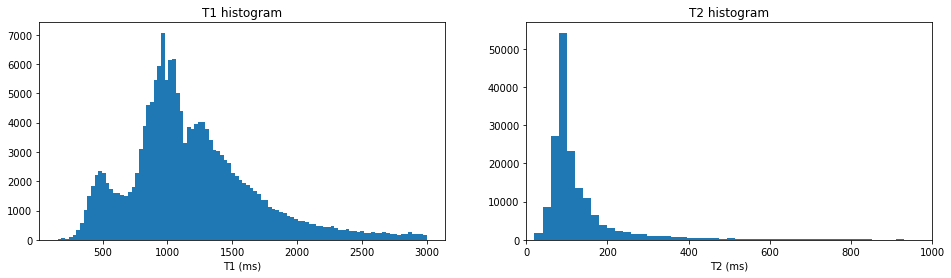

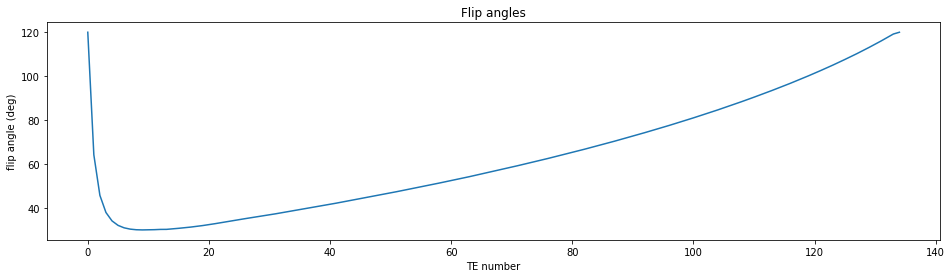

In [3]:
t1_t2_brain = np.load('data/t1t2_brain.npy')
flipangles = np.loadtxt('data/flipangles.txt')
flipangles_rad = flipangles * np.pi / 180
T = len(flipangles)
N_total = t1_t2_brain.shape[0]

plt.figure(figsize=figsize)
plt.subplot(1,2,1)
plt.hist(t1_t2_brain[:,0], 100)
plt.title('T1 histogram')
plt.xlabel('T1 (ms)')

plt.subplot(1,2,2)
plt.hist(t1_t2_brain[:,1], 100)
plt.title('T2 histogram')
plt.xlabel('T2 (ms)')
plt.xlim([0, 1000])

plt.figure(figsize=figsize)
plt.plot(flipangles)
plt.title('Flip angles')
plt.xlabel('TE number')
plt.ylabel('flip angle (deg)');

In [4]:
N = 1000
TR = 2500
TE = 4.936
e2s = 4

_ridx = np.random.permutation(N_total)
t1_t2_vals = t1_t2_brain[_ridx[:N], :]

def _gen_signal(t1_t2):
    t1, t2 = t1_t2
    return epg.FSE_signal(flipangles_rad, TE, t1, t2).squeeze()

with Pool(n_proc) as p:
    sig_mat = list((tqdm(p.imap(_gen_signal, t1_t2_vals), total=N)))

sig_mat = np.array(sig_mat)
print(sig_mat.shape)


(1000, 135)


Text(0, 0.5, 'signal (a.u.)')

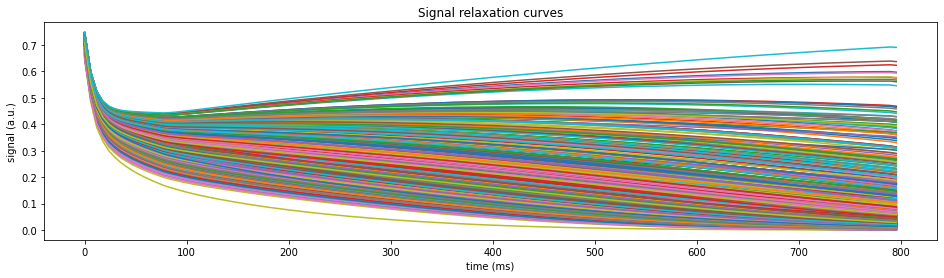

In [5]:
plt.figure(figsize=figsize)
plt.plot(np.arange(T)*(1+TE), sig_mat.T);
plt.title('Signal relaxation curves')
plt.xlabel('time (ms)')
plt.ylabel('signal (a.u.)')

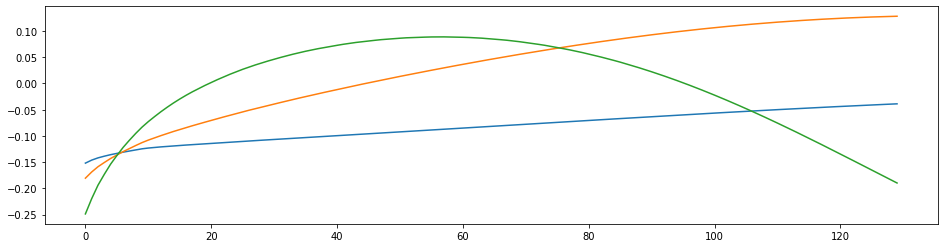

In [6]:
K = 3
u, s, v = np.linalg.svd(sig_mat[:,e2s:-1], full_matrices=False)
phi = v[:K,:]
plt.figure(figsize=figsize)
plt.plot(phi.T);

import cfl
cfl.writecfl('data/basis', phi)

In [380]:
class L0Proj(sp.prox.Prox):
    r"""Proximal operator for L0 Proj.

    Args:
        shape (tuple of ints): input shape
        lamda (float): regularization parameter

    """

    def __init__(self, shape, k, axes):
        self.k = k
        self.axes = axes

        super().__init__(shape)


    def top_k(self, input):
        r"""Top k max pooling
        Args:
            input(ndarray): convolutional feature in heigh x width x channel format
            k(int): if k==1, it is equal to normal max pooling
        Returns:
            ndarray: k x (height x width)
        """
        device = sp.backend.get_device(input)
        xp = device.xp

        topk_ind = xp.sort(input.T.argsort()[:,::-1][:,:self.k], axis=1)
        output = xp.zeros(input.shape[::-1])
        idx = xp.arange(len(topk_ind))
        output[idx, topk_ind.T] = input.T[idx, topk_ind.T]
        return output.T

    def _prox(self, alpha, input):
        with sp.backend.get_device(input):
            return self.top_k(input)
        
class OMP(sp.alg.Alg):
    
    def __init__(
            self,
            y,
            L,
            num_coeffs,
            use_sklearn=True,
            device=sp.cpu_device,
            DC=False,
            **kwargs):
        
        self.use_sklearn = use_sklearn
        
        if self.use_sklearn:
            assert device == sp.cpu_device, 'sklearn not compatible with GPU'
            self.max_iter = 1
        else:
            self.max_iter = y.shape[1]
            
        self.y = sp.to_device(y, device) # [1000, 135]
        self.L = sp.to_device(L, device)
        self.num_filters = self.L.shape[-1]
        self.num_coeffs = num_coeffs
        self.device = sp.Device(device)
        self.DC = DC
        
        self.dtype = self.y.dtype
        self.num_points, self.num_data = self.y.shape
        self.R_shape = (self.num_filters, self.num_data)

        xp = self.device.xp
        self.R = xp.zeros((self.num_filters, self.num_data), dtype=self.y.dtype)
        self.iter = 0
                
        super().__init__(self.max_iter)
        
    def _update(self):
        if self.use_sklearn:
            omp = OrthogonalMatchingPursuit(n_nonzero_coefs=self.num_coeffs)
            omp.fit(self.L, self.y)
            self.R = omp.coef_.T
        else:
            yi = self.y[:,self.iter][:,None]
            idxs, vals = self.omp_single(yi)
            self.R[idxs, self.iter] = vals.ravel()
            
    def omp_single(self, yi):
            xp = self.device.xp
            resid = yi
            idxs = []
            for k in range(self.num_coeffs):
                if k == 0 and self.DC:
                    ii = 0
                else:
                    z = abs(self.L.T.dot(resid))
                    ii = int(xp.argmax(z))
                idxs = idxs + [ii]
                Lsub = self.L[:, idxs]
                if self.device == sp.cpu_device:
                    rcond = None
                else:
                    rcond = -1
                vals = xp.linalg.lstsq(Lsub, yi, rcond=rcond)[0]
                resid = yi - Lsub.dot(vals)
            return idxs, vals.ravel()   
        
    def _done(self):
        return (self.iter >= self.max_iter)   
    
class SparseDecom(sp.app.App):
      
    def __init__(
            self,
            y,
            L,
            lamda=0.005,
            mode='l1',
            DC=False,
            use_sklearn=False,
            device=sp.cpu_device,
            show_pbar=True,
            **kwargs):
        self.y = sp.to_device(y, device) # [T, N]
        self.L = sp.to_device(L, device) # [T, K]
        self.lamda = lamda
        self.device = device
        self.mode = mode
        self.show_pbar = show_pbar

        self._get_params()
        
        if self.mode is 'omp':
            self.alg = OMP(self.y, 
                           self.L, 
                           self.lamda, 
                           use_sklearn=use_sklearn, 
                           DC=DC,
                           device=self.device)
            self._output = self.__output

        else:
            self.A_R = sp.linop.MatMul(
                self.R_shape,
                self.L)
            
            if self.mode is 'l1':
                proxg_R = sp.prox.L1Reg(self.R_shape, lamda)
            elif self.mode is 'l0':
                proxg_R = L0Proj(self.R_shape, lamda, 0)

            self.alg = sp.app.LinearLeastSquares(self.A_R, self.y, proxg=proxg_R, show_pbar=self.show_pbar, **kwargs).alg
         
        super().__init__(self.alg, show_pbar=self.show_pbar)
        self._output = self.__output



    def _get_params(self):
        self.device = sp.Device(self.device)
        self.dtype = self.y.dtype
        self.num_data = self.y.shape[-1]
        self.num_filters = self.L.shape[-1]
        self.num_points = self.L.shape[0]

        self.R_shape = (self.num_filters, self.num_data)
        
    def __output(self):
        if self.mode == 'omp':
            return self.alg.R
        else:
            return self.alg.x

        
class ShuffledNumbers(object):
    """Produces shuffled numbers between given range.

    Args:
        Arguements to numpy.arange.

    """
    def __init__(self, *args):
        self.numbers = np.arange(*args)
        np.random.shuffle(self.numbers)
        self.i = 0

    def __iter__(self):
        return self

    def __next__(self):
        return self.next()

    def next(self):
        ret = self.numbers[self.i]

        self.i += 1
        if self.i == len(self.numbers):
            np.random.shuffle(self.numbers)
            self.i = 0

        return ret

    
      
class SparseCoding(sp.app.App):
   
    
    def __init__(
            self,
            y,
            num_filters,
            batch_size,
            lamda=0.001,
            alpha=0.5,
            R_mode='omp',
            L_mode='ksvd',
            use_sklearn=False,
            L_init_mode='random',
            DC=False,
            skip_final_decomp=False,
            max_inner_iter=100,
            max_power_iter=10,
            max_iter=10,
            device=sp.cpu_device,
            **kwargs):
        self.y = sp.to_device(y, device) # [1000, 135]
        self.num_filters = num_filters
        self.batch_size = batch_size
        self.lamda = lamda
        self.alpha = alpha
        self.R_mode = R_mode
        self.L_mode = L_mode
        self.use_sklearn = use_sklearn
        self.max_inner_iter = max_inner_iter
        self.max_power_iter = max_power_iter
        self.max_iter = max_iter
        self.device = device
        self.L_init_mode = L_init_mode
        self.DC = DC
        self.skip_final_decomp=skip_final_decomp

        self._get_params()
        self._get_vars()
        self._get_alg()

        super().__init__(self.alg, show_pbar=True)


    def _get_params(self):
        self.device = sp.Device(self.device)
        self.dtype = self.y.dtype
        self.num_points, self.num_data = self.y.shape
        self.batch_size = min(self.num_data, self.batch_size)
        self.num_batches = self.num_data // self.batch_size
        
        self.L_shape = (self.num_points, self.num_filters)
        self.R_t_shape = (self.num_filters, self.batch_size)
   
    def _get_vars(self):
        self.t_idx = ShuffledNumbers(self.num_batches)
        xp = self.device.xp
        with self.device:
            self.y_t = xp.empty((self.num_points, self.batch_size),
                                dtype=self.dtype)
            
            if self.L_init_mode == 'random':
                self.L = sp.randn(self.L_shape, dtype=self.dtype,
                  device=self.device)
            elif self.L_init_mode == 'svd':
                uu, ss, vv = xp.linalg.svd(self.y, full_matrices=False)
                self.L = uu[:,:self.num_filters]
            elif self.L_init_mode == 'data':
                ridx = np.random.permutation(self.num_data)
                self.L = self.y[:, ridx[:self.num_filters]]
                
            if self.DC:
                self.L -= xp.mean(self.L, axis=0, keepdims=True)
                self.L[:, 0] = 1

            self.L /= xp.sum(xp.abs(self.L)**2,
                             axis=(0),
                             keepdims=True)**0.5

            self.L_old = xp.empty(self.L_shape, dtype=self.dtype)

            self.R = xp.zeros((self.num_filters, self.num_data), dtype=self.dtype)
            self.R_t = xp.zeros((self.num_filters, self.batch_size), dtype=self.dtype)
            self.current_resid = -1
    def _get_alg(self):
        
        def min_R_t():
            self.R_t = SparseDecom(
                self.y_t,
                self.L,
                lamda=self.lamda,
                mode=self.R_mode,
                use_sklearn=self.use_sklearn,
                DC=self.DC,
                max_power_iter=self.max_power_iter,
                max_iter=self.max_inner_iter,
                device=self.device, show_pbar=False).run()

        def min_L_lls():
            
            self.A_L = sp.linop.RightMatMul(
                self.L_shape,
                self.R_t)

            mu = (1 - self.alpha) / self.alpha

            proxg_L = sp.prox.L2Proj(
                self.L.shape, 1, axes=[0])

            sp.app.LinearLeastSquares(self.A_L, self.y_t, x=self.L,
                                      z=self.L_old,
                                      proxg=proxg_L,
                                      lamda=mu,
                                      max_power_iter=self.max_power_iter,
                                      max_iter=self.max_inner_iter, show_pbar=False).run()
               
        def min_L_ksvd():
            if self.L_mode == 'ksvd':
                approx = False
            else:
                approx = True
            for k in np.random.permutation(self.num_filters):
                if k > 0 or (not self.DC):
                    self.update_filter(k, approx=approx)
                
        if self.L_mode == 'lls':
            min_L = min_L_lls
        else:
            min_L = min_L_ksvd
            
        self.alg = sp.alg.AltMin(min_R_t, min_L, max_iter=self.max_iter)

        
    def update_filter(self, k, approx=False):
        xp = self.device.xp
        lk = self.L[:, k][:,None]
        rk = self.R_t[k, :][None,:]
        idx = rk.ravel() != 0
        if np.sum(idx) > 0:
#             print(rk)
            if approx:
                self.L[:, k] = 0
                g = rk[:, idx].T
                yI = self.y_t[:, idx]
                RI = self.R_t[:, idx]
                d = yI.dot(g) - L2.dot(RI).dot(g)
                d /= xp.linalg.norm(d)
                g = yI.T.dot(d) - (self.L.dot(RI)).T.dot(d)
                self.L[:, k] = d.ravel()
                self.R_t[k, idx] = g.T
            else:
                Ek = self.y_t - self.L.dot(self.R_t) + lk.dot(rk)
                EkR = Ek[:, idx]
                uu, ss, vv = xp.linalg.svd(EkR, full_matrices=False)
                self.L[:, k] = uu[:,0]
                self.R_t[k, idx] = vv[0,:] * ss[0]          
    
    def _pre_update(self):
        t = self.t_idx.next()
        t_start = t * self.batch_size
        t_end = (t + 1) * self.batch_size

        sp.copyto(self.y_t, self.y[:,t_start:t_end])
        sp.copyto(self.L_old, self.L)
    
    def _summarize(self):
        if self.show_pbar:
            xp = self.device.xp
            self.current_resid = xp.linalg.norm(self.y_t - self.L.dot(self.R_t))
            self.pbar.set_postfix(resid='{0:.2E}'.format(self.current_resid))

    def _output(self):  
        if not self.skip_final_decomp:
            self.R = SparseDecom(
                    self.y,
                    self.L,
                    lamda=self.lamda,
                    mode=self.R_mode,
                    use_sklearn=self.use_sklearn,
                    max_power_iter=self.max_power_iter,
                    max_iter=self.max_inner_iter,
                    device=self.device, show_pbar=True).run()
        return self.L, self.R



        


<IPython.core.display.Javascript object>


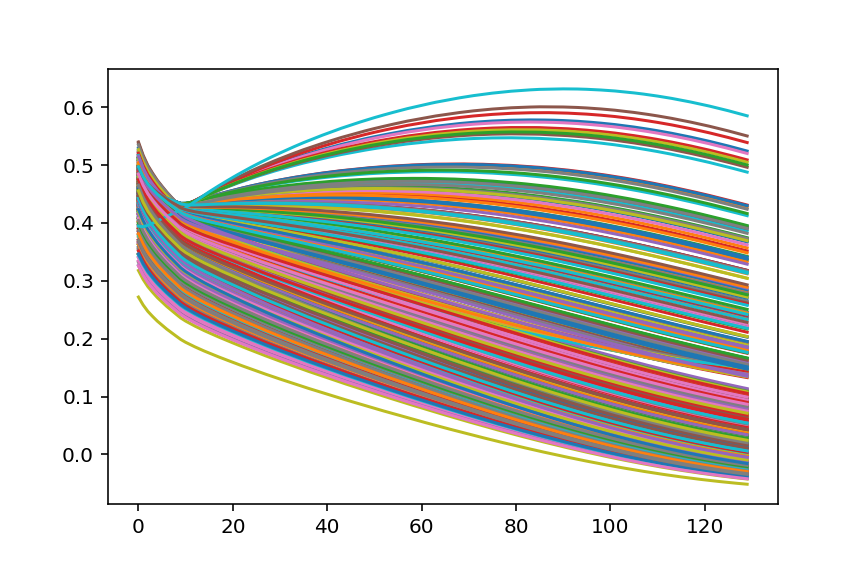

(130, 1000)
10.26202354666507


<IPython.core.display.Javascript object>


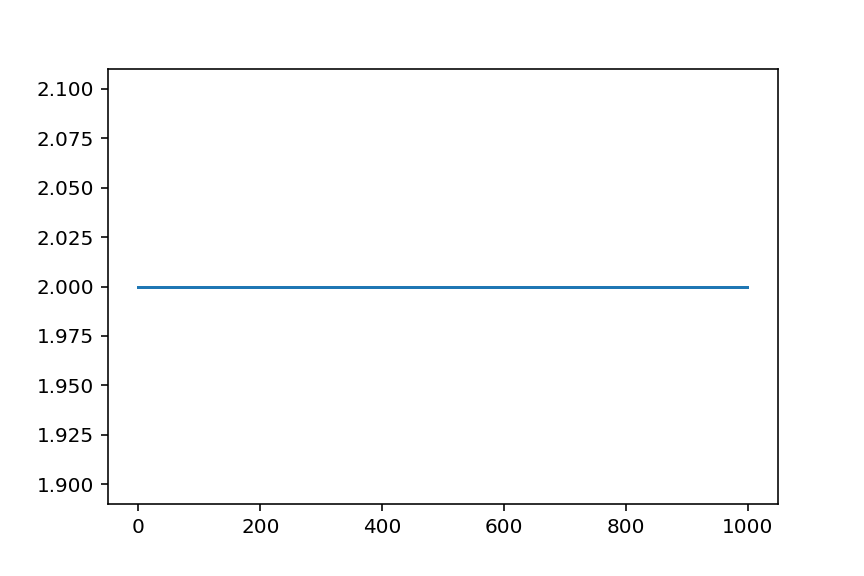

In [382]:
y = sig_mat[:,:130].T
L = phi.T
# device = sp.Device(3)
device = sp.cpu_device
with device:
    app = SparseDecom(y, L, 2, mode='omp', use_sklearn=False, max_iter=100, max_power_iter=20, device=device)
    x = app.run()
R = sp.to_device(x, sp.cpu_device)
plt.figure()
yhat = L.dot(R)
print(yhat.shape)
print(np.linalg.norm(y.ravel() - yhat.ravel()))
plt.plot(yhat);


plt.figure()
plt.plot(np.sum(R!=0,0));


(130, 20) (20, 1000)


<IPython.core.display.Javascript object>


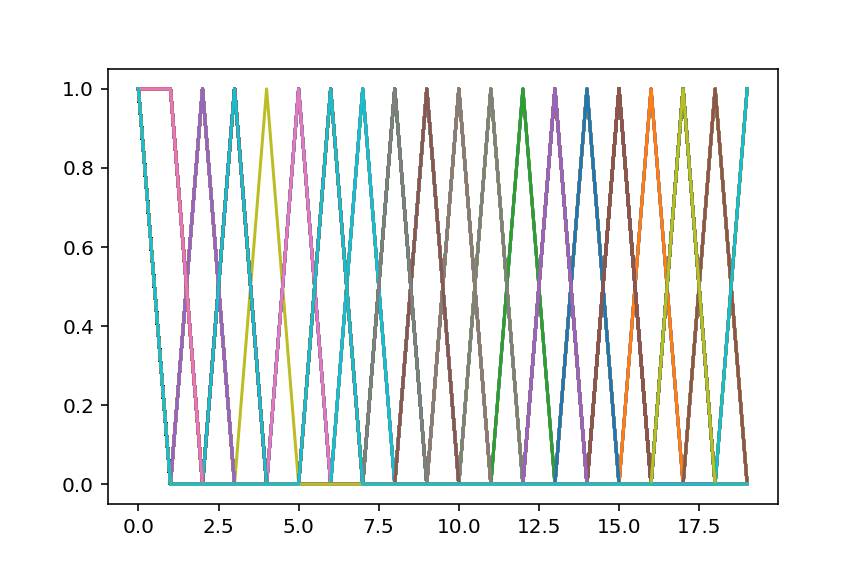

<IPython.core.display.Javascript object>


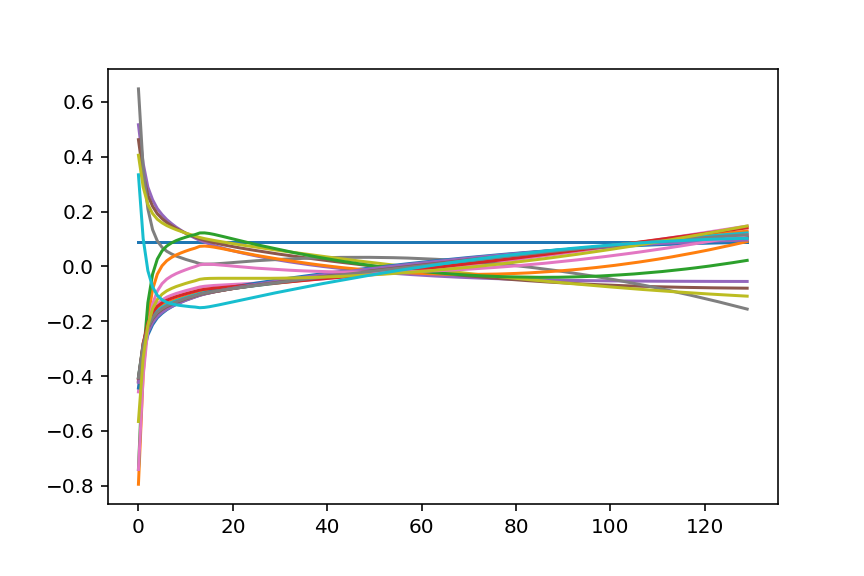

<IPython.core.display.Javascript object>


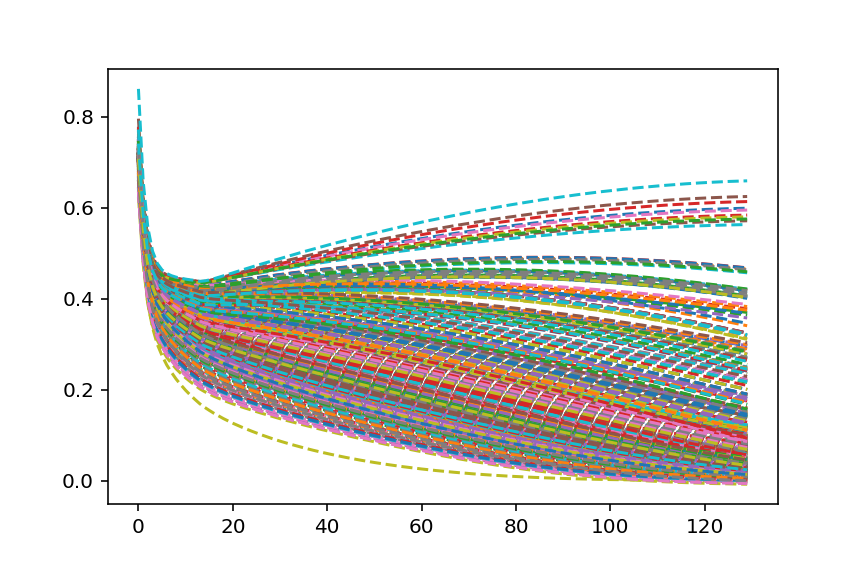

(130, 1000)
0.007996167312814688


<IPython.core.display.Javascript object>


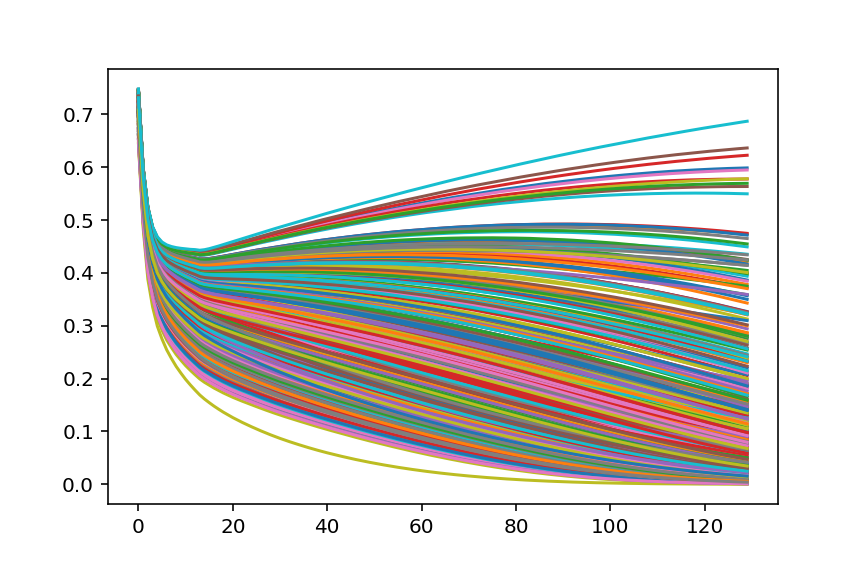

In [383]:
device = sp.Device(3)
# device = sp.cpu_device
num_filters = 20
num_nonzero_coeffs = 2
y = sig_mat[:,:130].T
with device:
    app = SparseCoding(y, num_filters, L_init_mode='data', batch_size=100, R_mode='omp', use_sklearn=False, L_mode='ksvd',
                       lamda=num_nonzero_coeffs, DC=True,
                       alpha=0.5, max_inner_iter=10, max_iter=100, max_power_iter=30)
    x = app.run()

Lhat, Rhat = x[0], x[1]
print(Lhat.shape, Rhat.shape)

plt.figure()
plt.plot(Rhat != 0);

plt.figure()
plt.plot(Lhat)

plt.figure()
yhat = sp.linop.MatMul(Rhat.shape, Lhat) * Rhat
print(yhat.shape)
print(np.linalg.norm(y.ravel() - yhat.ravel()) / np.linalg.norm(y.ravel()))
plt.plot(yhat, '--');

plt.figure()
plt.plot(y);


In [419]:
   
# cfimg = cfl.readcfl('data/cfimg-091').squeeze()
# img = cfimg[...,0]
with np.load('data/brain.npz') as data:
#     for key in data.keys():
#         print(key)
    img = np.array(data['im'])
print(img.shape)
filter_size = [8, 8]
strides = [f for f in filter_size]
num_filters = 20
num_nonzero_coeffs = 5

device = sp.cpu_device
img_blocks = sp.array_to_blocks(img, filter_size, strides)
print(img_blocks.shape)
# L = np.random.randn(filter_size[0], filter_size[1], num_filters)

y_img_blocks = img_blocks.reshape((-1, np.prod(filter_size))).T
print(y_img_blocks.shape)
# remove patches with little-to-no signal
_nrms = np.linalg.norm(y_img_blocks, axis=0)
_mean_nrms = np.mean(_nrms)
print(_mean_nrms)
y_img_blocks_pruned = y_img_blocks[:, _nrms > .5 * _mean_nrms]
print(y_img_blocks.shape, y_img_blocks_pruned.shape)
# plt.figure()
# plt.hist(_nrms, 100)
# plt.figure()
# plt.hist(_nrms[_nrms > .5 * _mean_nrms], 100)

with device:
#     app = SparseDecom(img_blocks.reshape((-1, 16*16)).T, L.reshape((16*16, -1)), 1, mode='omp', use_sklearn=False, max_iter=100, max_power_iter=20, device=device)
#     out_flat = app.run()
    app = SparseCoding(y_img_blocks_pruned, 
                       num_filters, 
                       batch_size=500, 
                       R_mode='omp', 
                       use_sklearn=False, 
                       L_mode='ksvd', 
                       L_init_mode='data',
                       DC=True,
                       lamda=num_nonzero_coeffs,
                       alpha=0.5,
                       max_inner_iter=100,
                       max_iter=50, 
                       max_power_iter=30,
                       skip_final_decomp=True)
    out = app.run()
    app2 = SparseDecom(y_img_blocks, out[0], num_nonzero_coeffs, 
                      mode='omp', 
                      DC=True,
                      use_sklearn=False, 
                      max_iter=100, 
                      max_power_iter=20, 
                      device=device)
    out2 = app2.run()

(512, 512)
(64, 64, 8, 8)
(64, 4096)
1.3557920899446008
(64, 4096) (64, 2087)


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



(8, 8, 20) (20, 64, 64)


<IPython.core.display.Javascript object>


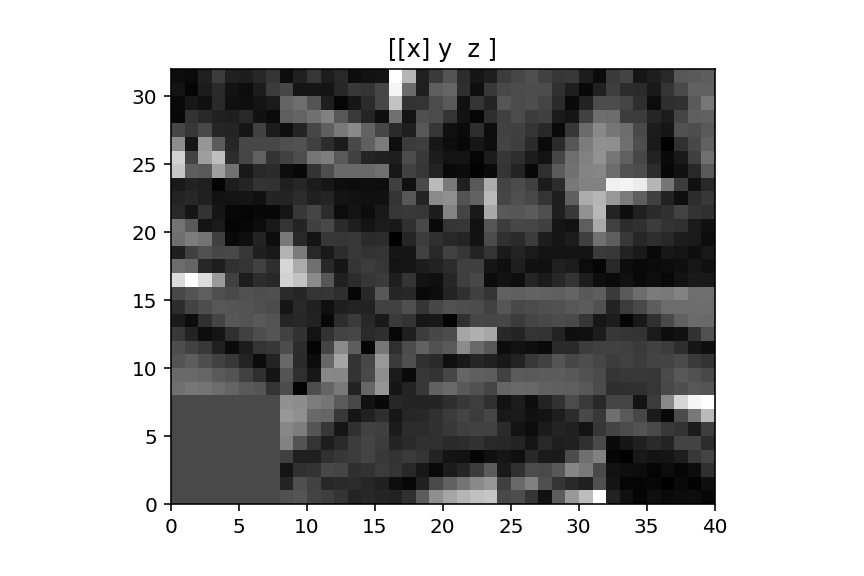

In [428]:
Lhat_flat, Rhat_flat = out[0], out2
Lhat = Lhat_flat.reshape((filter_size[0], filter_size[1], num_filters))
Rhat = Rhat_flat.reshape((num_filters, *img_blocks.shape[:2]))

print(Lhat.shape, Rhat.shape)
# out = sp.to_device(out_flat.T.reshape(*img_blocks.shape[:2], -1))


# print(out.shape)
# %matplotlib notebook
# pl.ImagePlot(out, x=0, y=1, z=2)

pl.ImagePlot(Lhat, x=0, y=1, z=2, interpolation='nearest')

<IPython.core.display.Javascript object>


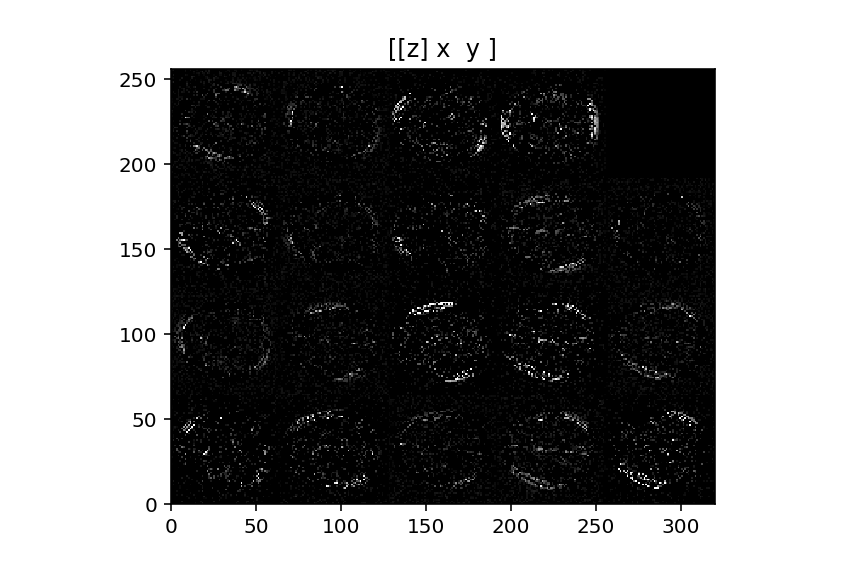

In [429]:
pl.ImagePlot(Rhat[1:,...], z=0, x=1, y=2)

(64, 4096)


<IPython.core.display.Javascript object>


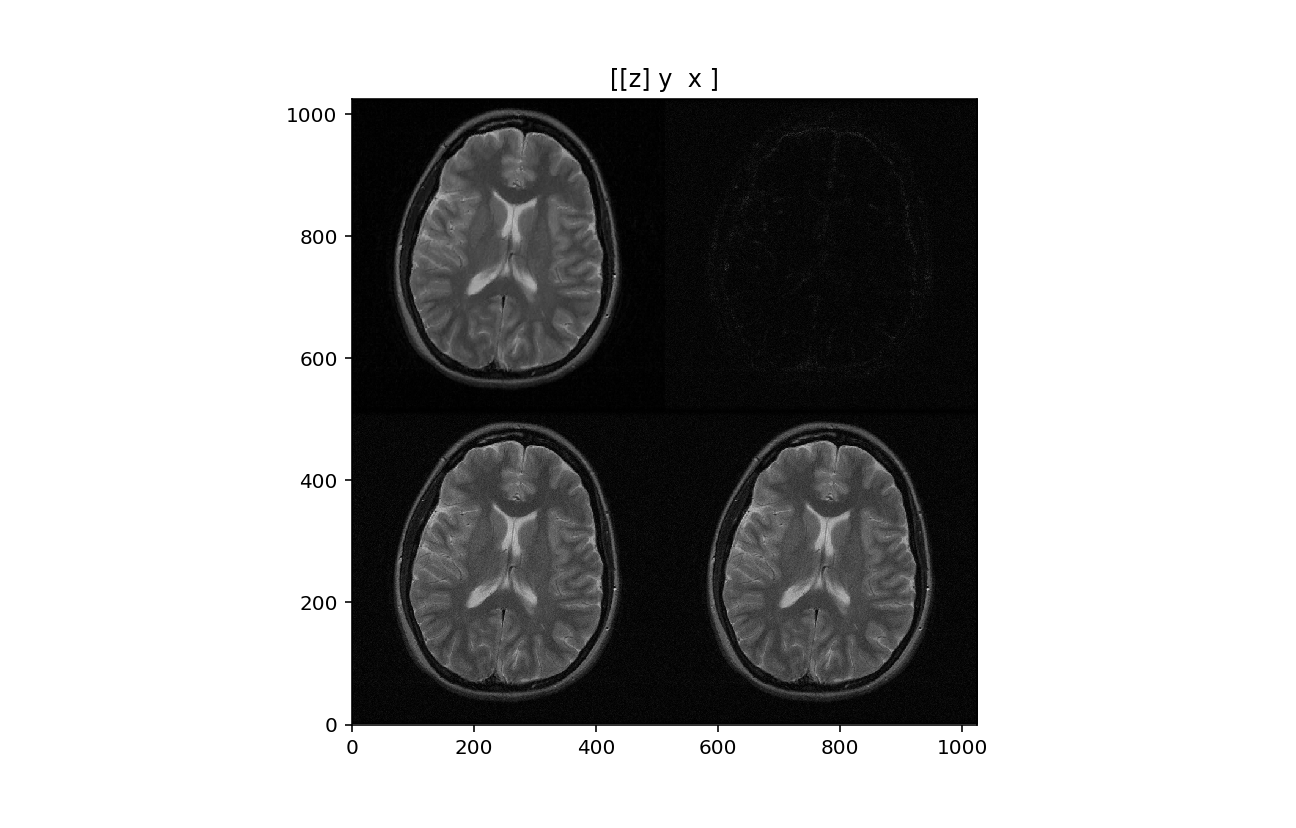

In [430]:
img_hat_flat = Lhat_flat.dot(Rhat_flat)
print(img_hat_flat.shape)
img_hat_blocks = img_hat_flat.T.reshape(img_blocks.shape)
img_hat = sp.blocks_to_array(img_hat_blocks, img.shape, filter_size, strides)
img2 = sp.blocks_to_array(img_blocks, img.shape, filter_size, strides)

pl.ImagePlot(np.stack((img, img2, img_hat, img-img_hat))[:,::-1,...], z=0)